In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
import optuna

In [22]:
file_path = './datasets/sentimen_fomo_merge_10000_fix'

In [23]:
try:
    df = pd.read_csv(file_path)
    if 'label' in df.columns and 'sentiment' not in df.columns: df.rename(columns={'label': 'sentiment'}, inplace=True)
    print("File CSV berhasil dimuat.")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di '{file_path}'.")
   

File CSV berhasil dimuat.


In [24]:
print("\n--- 1. Exploratory Data Analysis (EDA) ---")
print("Info Dataset:")
df.info()
print("\n5 Baris Pertama:")
print(df.head())
print("\nDistribusi Label:")
# Menggunakan 'final_label'
print(df['sentiment'].value_counts())


--- 1. Exploratory Data Analysis (EDA) ---
Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9546 entries, 0 to 9545
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   created_at       9546 non-null   object
 1   username         3743 non-null   object
 2   full_text        9546 non-null   object
 3   location         2119 non-null   object
 4   favorite_count   9546 non-null   int64 
 5   retweet_count    9546 non-null   int64 
 6   cleaned_text     9546 non-null   object
 7   normalized_text  9546 non-null   object
 8   stemmed_text     9546 non-null   object
 9   tokens           9546 non-null   object
 10  bert_sentiment   9546 non-null   object
dtypes: int64(2), object(9)
memory usage: 820.5+ KB

5 Baris Pertama:
                  created_at username  \
0  2025-04-24 17:44:05+00:00      NaN   
1  2025-04-24 17:06:52+00:00      NaN   
2  2025-04-24 16:08:49+00:00      NaN   
3  2025-04-24 15

# --- 1. Exploratory Data Analysis (EDA) ---


Visualisasi EDA disimpan sebagai 'label_distribution.png'


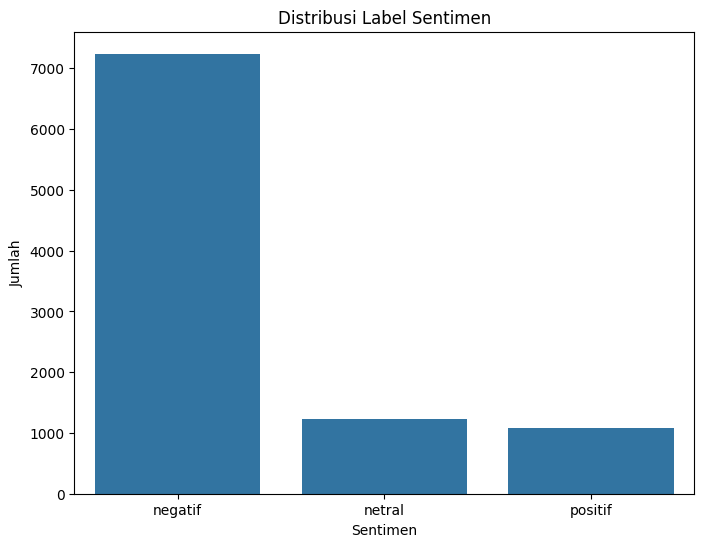

In [25]:
plt.figure(figsize=(8, 6))
# Menggunakan 'final_label'
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.savefig('label_distribution.png')
print("\nVisualisasi EDA disimpan sebagai 'label_distribution.png'")


# --- 2. Persiapan Data ---

In [26]:
print("\n--- 2. Persiapan Data ---")
X = df['normalized_text']
# Menggunakan 'final_label'
y = df['sentiment']



--- 2. Persiapan Data ---


In [27]:
label_map = {'positif': 2, 'netral': 1, 'negatif': 0}
y_encoded = y.map(label_map)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Ukuran data latih: {X_train.shape[0]}")
print(f"Ukuran data uji: {X_test.shape[0]}")

Ukuran data latih: 7636
Ukuran data uji: 1910


# --- 3. Skenario 1: Model Baseline (SVM & Naive Bayes) ---

In [29]:
print("\n--- 3. Skenario 1: Model Baseline (SVM & Naive Bayes) dengan SMOTE ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train); X_test_tfidf = tfidf_vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
svm_model = SVC(kernel='linear', random_state=42); svm_model.fit(X_train_resampled, y_train_resampled)
nb_model = MultinomialNB(); nb_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test_tfidf); y_pred_nb = nb_model.predict(X_test_tfidf)
report_svm = classification_report(y_test, y_pred_svm, target_names=label_map.keys(), output_dict=True)
report_nb = classification_report(y_test, y_pred_nb, target_names=label_map.keys(), output_dict=True)
results = {'SVM (dengan SMOTE)': report_svm['weighted avg'], 'Naive Bayes (dengan SMOTE)': report_nb['weighted avg']}
print("Hasil Skenario 1 (Baseline dengan SMOTE) selesai.")


--- 3. Skenario 1: Model Baseline (SVM & Naive Bayes) dengan SMOTE ---
Hasil Skenario 1 (Baseline dengan SMOTE) selesai.


# --- PENAMBAHAN: HITUNG CLASS WEIGHT ---

In [30]:
print("\n--- Menghitung Class Weight untuk Model Deep Learning ---")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Ubah ke tensor PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(f"Bobot Kelas yang dihitung: {class_weights_tensor}")


--- Menghitung Class Weight untuk Model Deep Learning ---
Bobot Kelas yang dihitung: tensor([0.4395, 2.5973, 2.9426])


# --- 4. Skenario 2: Model Sekuensial (BiLSTM dengan PyTorch) ---

In [31]:
print("\n--- 4. Skenario 2: Model Sekuensial (BiLSTM) dengan Class Weight ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)
word_counts = Counter(word for text in X_train for word in text.split()); vocab = sorted(word_counts, key=word_counts.get, reverse=True); word_to_idx = {word: i+2 for i, word in enumerate(vocab)}; word_to_idx['<PAD>'] = 0; word_to_idx['<UNK>'] = 1
def text_to_sequence(text, word_to_idx): return [word_to_idx.get(word, 1) for word in text.split()]
X_train_seq = [text_to_sequence(text, word_to_idx) for text in X_train]; X_test_seq = [text_to_sequence(text, word_to_idx) for text in X_test]
def pad_sequences(sequences, max_len=100):
    padded = np.zeros((len(sequences), max_len), dtype=np.int64);
    for i, seq in enumerate(sequences):
        seq_len = len(seq)
        if seq_len > 0: padded[i, :min(seq_len, max_len)] = seq[:max_len]
    return padded
X_train_pad = pad_sequences(X_train_seq); X_test_pad = pad_sequences(X_test_seq)
class SentimentDataset(Dataset):
    def __init__(self, X, y): self.X = torch.from_numpy(X).long(); self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]
train_dataset_lstm = SentimentDataset(X_train_pad, y_train.to_numpy()); test_dataset_lstm = SentimentDataset(X_test_pad, y_test.to_numpy())
train_loader = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True); test_loader = DataLoader(test_dataset_lstm, batch_size=32)
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, n_layers=2, dropout=0.3):
        super().__init__(); self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0); self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, bidirectional=True, batch_first=True, dropout=dropout); self.fc = nn.Linear(hid_dim * 2, out_dim); self.dropout = nn.Dropout(dropout)
    def forward(self, text):
        embedded = self.dropout(self.embedding(text)); outputs, (hidden, cell) = self.lstm(embedded); hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)); return self.fc(hidden)
bilstm_model = BiLSTMClassifier(len(word_to_idx), 128, 64, 3).to(device)
optimizer = torch.optim.Adam(bilstm_model.parameters())
# --- Masukkan bobot ke loss function ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

print("Memulai pelatihan BiLSTM..."); bilstm_model.train()
for epoch in range(15):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device); optimizer.zero_grad(); output = bilstm_model(data); loss = criterion(output, target); loss.backward(); optimizer.step()
    print(f'Epoch BiLSTM: {epoch+1}, Loss: {loss.item():.4f}')
bilstm_model.eval(); all_preds = []
with torch.no_grad():
    for data, target in test_loader:
        outputs = bilstm_model(data.to(device)); _, predicted = torch.max(outputs.data, 1); all_preds.extend(predicted.cpu().numpy())
y_pred_bilstm = np.array(all_preds)
report_bilstm = classification_report(y_test, y_pred_bilstm, target_names=label_map.keys(), output_dict=True)
results['BiLSTM (Class Weight)'] = report_bilstm['weighted avg']
print("Hasil Skenario 2 (BiLSTM dengan Class Weight) selesai.")


--- 4. Skenario 2: Model Sekuensial (BiLSTM) dengan Class Weight ---
Memulai pelatihan BiLSTM...
Epoch BiLSTM: 1, Loss: 0.8113
Epoch BiLSTM: 2, Loss: 0.7356
Epoch BiLSTM: 3, Loss: 0.4709
Epoch BiLSTM: 4, Loss: 0.5105
Epoch BiLSTM: 5, Loss: 0.3864
Epoch BiLSTM: 6, Loss: 0.1682
Epoch BiLSTM: 7, Loss: 0.4014
Epoch BiLSTM: 8, Loss: 0.2813
Epoch BiLSTM: 9, Loss: 0.0782
Epoch BiLSTM: 10, Loss: 0.1109
Epoch BiLSTM: 11, Loss: 0.1850
Epoch BiLSTM: 12, Loss: 0.0346
Epoch BiLSTM: 13, Loss: 0.0920
Epoch BiLSTM: 14, Loss: 0.0375
Epoch BiLSTM: 15, Loss: 0.0253
Hasil Skenario 2 (BiLSTM dengan Class Weight) selesai.


# --- 5. Skenario 3: Model Transformer (IndoBERT) ---

In [ ]:
print("\n--- 5. Skenario 3: IndoBERT dengan Class Weight ---")
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME)
train_df_hf = pd.DataFrame({'text': X_train.to_list(), 'label': y_train.to_list()})
test_df_hf = pd.DataFrame({'text': X_test.to_list(), 'label': y_test.to_list()})
train_dataset_hf = HFDataset.from_pandas(train_df_hf)
test_dataset_hf = HFDataset.from_pandas(test_df_hf)
def tokenize_function(examples): return tokenizer_bert(examples['text'], padding='max_length', truncation=True, max_length=128)
train_tokenized = train_dataset_hf.map(tokenize_function, batched=True)
test_tokenized = test_dataset_hf.map(tokenize_function, batched=True)
def model_init(): return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
def compute_metrics(p): preds = np.argmax(p.predictions, axis=1); return {"accuracy": accuracy_score(p.label_ids, preds)}
def objective(trial):
    training_args = TrainingArguments(
        output_dir='./results_optuna',
        eval_strategy="epoch",
        save_strategy="epoch", 
        learning_rate=trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        per_device_train_batch_size=8,
        num_train_epochs=trial.suggest_int("num_train_epochs", 2, 5),
        weight_decay=trial.suggest_float("weight_decay", 0.01, 0.1),
        logging_steps=500,
        disable_tqdm=True,
    )
    trainer = CustomTrainer(model_init=model_init, args=training_args, train_dataset=train_tokenized, eval_dataset=test_tokenized, compute_metrics=compute_metrics)
    trainer.train()
    return trainer.evaluate()['eval_accuracy']

print("Memulai optimalisasi hyperparameter untuk IndoBERT...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Hyperparameter terbaik:", study.best_params)

final_training_args = TrainingArguments(
    output_dir='./results_final',
    eval_strategy="epoch",
    save_strategy="epoch",  
    learning_rate=study.best_params['learning_rate'],
    per_device_train_batch_size=8,
    num_train_epochs=study.best_params['num_train_epochs'],
    weight_decay=study.best_params['weight_decay'],
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
)
final_trainer = CustomTrainer(model_init=model_init, args=final_training_args, train_dataset=train_tokenized, eval_dataset=test_tokenized, compute_metrics=compute_metrics)
print("Memulai fine-tuning final IndoBERT...")
final_trainer.train()
predictions = final_trainer.predict(test_tokenized)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
report_bert = classification_report(y_test, y_pred_bert, target_names=label_map.keys(), output_dict=True)
results['IndoBERT (Class Weight)'] = report_bert['weighted avg']
print("Hasil Skenario 3 (IndoBERT dengan Class Weight) selesai.")

# --- 6. Perbandingan Akhir ---


--- 6. Perbandingan Akhir Semua Model ---
                            Accuracy  Precision    Recall  F1-Score
SVM (dengan SMOTE)          0.780105   0.804329  0.780105  0.789190
Naive Bayes (dengan SMOTE)  0.711518   0.804668  0.711518  0.737164
BiLSTM (Class Weight)       0.827749   0.844352  0.827749  0.832254
IndoBERT (Class Weight)     0.933508   0.934098  0.933508  0.933524

Plot perbandingan disimpan sebagai 'model_comparison_all.png'
Confusion matrix IndoBERT disimpan sebagai 'confusion_matrix_indobert.png'


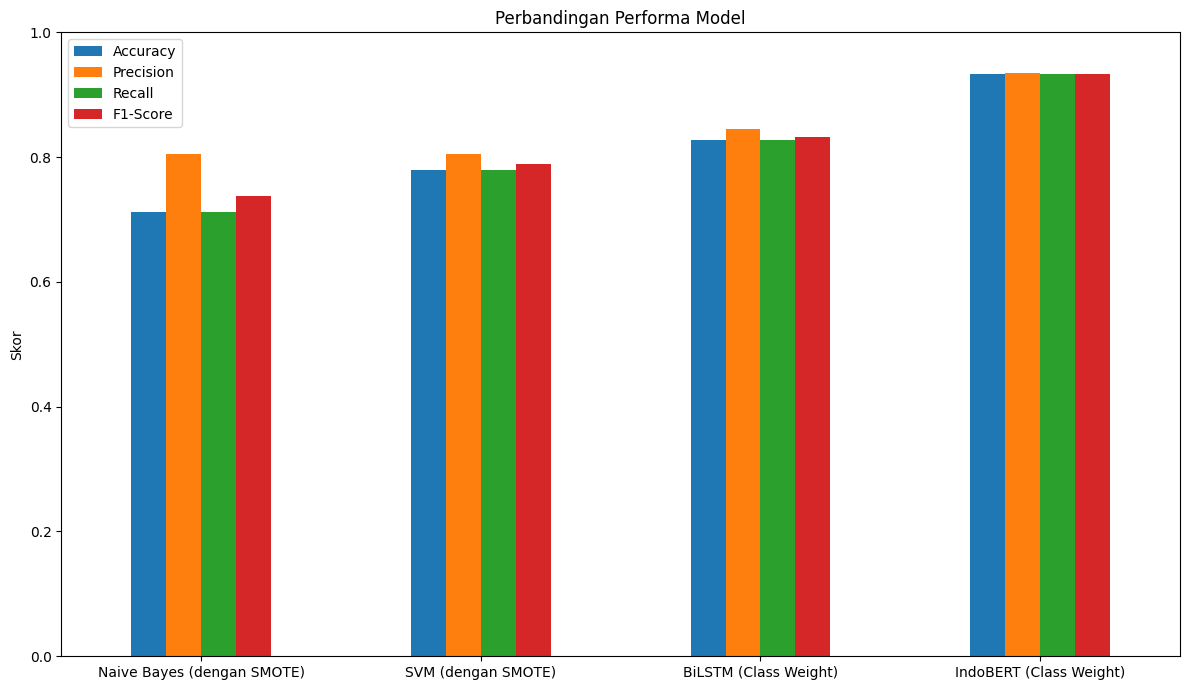

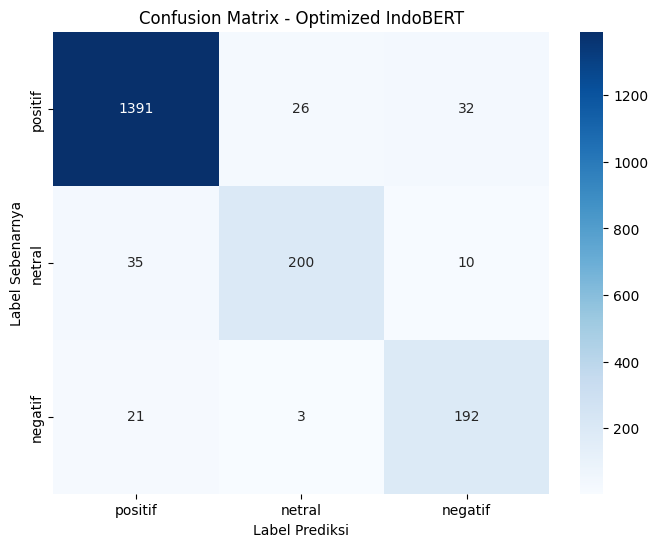

In [33]:
print("\n--- 6. Perbandingan Akhir Semua Model ---")
results_df = pd.DataFrame(results).T
results_df.rename(columns={'precision': 'Precision', 'recall': 'Recall', 'f1-score': 'F1-Score'}, inplace=True)
results_df['Accuracy'] = [
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_bilstm),
    accuracy_score(y_test, y_pred_bert)
]
results_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
print(results_df)

results_df.sort_values('F1-Score').plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Perbandingan Performa Model')
plt.ylabel('Skor')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig('model_comparison_all.png')
print("\nPlot perbandingan disimpan sebagai 'model_comparison_all.png'")

cm = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix - Optimized IndoBERT')
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.savefig('confusion_matrix_indobert.png')
print("Confusion matrix IndoBERT disimpan sebagai 'confusion_matrix_indobert.png'")

In [34]:
# print("\n--- 7. Mengekspor Model dan Tokenizer ---")
# export_directory = "indobert_fomo_model_final"
# final_trainer.save_model(export_directory)
# tokenizer_bert.save_pretrained(export_directory)
# print(f"Model dan Tokenizer berhasil diekspor ke direktori: '{export_directory}'")